In [20]:
import h5py
import hdf5plugin
import numpy as np
import itertools
import torch
from torch_geometric.data import Data, Dataset
import os

#process data so that number of h_bb=qcd=num_datapoints
files = os.listdir("/higgs/train")
def processData_even(files, num_datapoints = 1000):
#     filename = "/higgs/train/ntuple_merged_44.h5"
#     h5s = []
#     for i in range(10):
#         h5s.append(h5py.File(filename,'r'))
    fs = []
    for f in files:
        if f[-3:] == ".h5": fs.append(f)

    # filename = "/higgs/train/ntuple_merged_44.h5"
    h5s = []
    for i in range(10):
        h5s.append(h5py.File("/higgs/train/"+fs[i],'r'))

    params_3 = ['sv_ptrel',
              'sv_erel',
              'sv_phirel',
              'sv_etarel',
              'sv_deltaR',
              'sv_pt',
              'sv_mass',
              'sv_ntracks',
              'sv_normchi2',
              'sv_dxy',
              'sv_dxysig',
              'sv_d3d',
              'sv_d3dsig',
              'sv_costhetasvpv'
             ]

    params_2 = ['track_ptrel',     
              'track_erel',     
              'track_phirel',     
              'track_etarel',     
              'track_deltaR',
              'track_drminsv',     
              'track_drsubjet1',     
              'track_drsubjet2',
              'track_dz',     
              'track_dzsig',     
              'track_dxy',     
              'track_dxysig',     
              'track_normchi2',     
              'track_quality',     
              'track_dptdpt',     
              'track_detadeta',     
              'track_dphidphi',     
              'track_dxydxy',     
              'track_dzdz',     
              'track_dxydz',     
              'track_dphidxy',     
              'track_dlambdadz',     
              'trackBTag_EtaRel',     
              'trackBTag_PtRatio',     
              'trackBTag_PParRatio',     
              'trackBTag_Sip2dVal',     
              'trackBTag_Sip2dSig',     
              'trackBTag_Sip3dVal',     
              'trackBTag_Sip3dSig',     
              'trackBTag_JetDistVal'
             ]


    labels_qcd = {"label_QCD_b": 53, "label_QCD_bb":51, "label_QCD_c":54,"label_QCD_cc":52,"label_QCD_others": 55}
    label_H_bb = 41
    num_datapoints = num_datapoints
    hbb_count = 0
    qcd_count = 0

    # track features
    X = []

    # SV features
    Y = []

    # labels
    y = []
    edge_indices = []
    for h5 in h5s:
        if qcd_count >= num_datapoints and hbb_count >= num_datapoints:
            break
        num_jets = h5["event_no"].shape[0]
        n_particles = h5["track_dxydxy"].shape[-1]
        n_vertices = h5["sv_phirel"].shape[-1]
        for jet in range(num_jets):

            if h5["fj_label"][jet] in list(labels_qcd.values()) and qcd_count < num_datapoints:
                qcd_count += 1
                y.append([0,1])
            elif h5["fj_label"][jet] == label_H_bb and hbb_count < num_datapoints:
                hbb_count += 1
                y.append([1,0])
            else: continue

            x = []
            for feature in params_2:
                x.append(h5[feature][jet])
            X.append(np.array(x).reshape(n_particles,-1))

            y1 = []
            for feature in params_3:
                y1.append(h5[feature][jet])
            Y.append(np.array(y1).reshape(n_vertices,-1))

            # complete graph has n_particles*(n_particles-1)/2 edges, here we double count each edge, so has  n_particles*(n_particles-1) total edges
            pairs = np.stack([[m, n] for (m, n) in itertools.product(range(n_particles), range(n_particles)) if m != n])
            edge_index = torch.tensor(pairs, dtype=torch.long)
            edge_index = pairs.transpose()
            edge_indices.append(edge_index)

            # if jet > 1000:
                # break
            if qcd_count >= num_datapoints and hbb_count >= num_datapoints:
                break
            print("qcd: ", qcd_count, " hbb: ", hbb_count)
        return X, Y, y

In [1]:
import keras
import numpy as np
#!brew install hdf5
#!pip3 install tables
import tables
from keras.models import Model
from keras.layers import Input, Dense, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

2024-06-09 18:53:24.337237: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
features = ['track_ptrel',     
          'track_erel',     
          'track_phirel',     
          'track_etarel',     
          'track_deltaR',
          'track_drminsv',     
          'track_drsubjet1',     
          'track_drsubjet2',
          'track_dz',     
          'track_dzsig',     
          'track_dxy',     
          'track_dxysig',     
          'track_normchi2',     
          'track_quality',     
          'track_dptdpt',     
          'track_detadeta',     
          'track_dphidphi',     
          'track_dxydxy',     
          'track_dzdz',     
          'track_dxydz',     
          'track_dphidxy',     
          'track_dlambdadz',     
          'trackBTag_EtaRel',     
          'trackBTag_PtRatio',     
          'trackBTag_PParRatio',     
          'trackBTag_Sip2dVal',     
          'trackBTag_Sip2dSig',     
          'trackBTag_Sip3dVal',     
          'trackBTag_Sip3dSig',     
          'trackBTag_JetDistVal']

spectators = ['track_mass', 'track_pt']

labels = ['fj_isQCD*sample_isQCD',
          'fj_isH*fj_isBB']

nfeatures = len(features)
nspectators = len(spectators)
nlabels = len(labels)

In [3]:
def get_features_labels(file_name, remove_mass_pt_window=True):
    # load file
    h5file = tables.open_file(file_name, 'r')
    njets = getattr(h5file.root,features[0]).shape[0]

    # allocate arrays
    feature_array = np.zeros((njets,nfeatures))
    #print("feature_array: ", feature_array.shape)
    spec_array = np.zeros((njets,nspectators))
    #print("spec_array: ", feature_array.shape)
    label_array = np.zeros((njets,nlabels))
    #print("label_array: ", feature_array.shape)

    # load feature arrays
    for (i, feat) in enumerate(features):
        #print(feature_array.shape)
        #print(getattr(h5file.root,feat))
        feature_array[:,i] = getattr(h5file.root,feat)[:,i]
        

    # load spectator arrays
    for (i, spec) in enumerate(spectators):
        spec_array[:,i] = getattr(h5file.root,spec)[:, i]

    # load labels arrays
    for (i, label) in enumerate(labels):
        prods = label.split('*')
        prod0 = prods[0]
        prod1 = prods[1]
        fact0 = getattr(h5file.root,prod0)[:]
        fact1 = getattr(h5file.root,prod1)[:]
        label_array[:,i] = np.multiply(fact0,fact1)

    # remove samples outside mass/pT window
    if remove_mass_pt_window:
        feature_array = feature_array[(spec_array[:,0] > 40) & (spec_array[:,0] < 200) & (spec_array[:,1] > 300) & (spec_array[:,1] < 2000)]
        label_array = label_array[(spec_array[:,0] > 40) & (spec_array[:,0] < 200) & (spec_array[:,1] > 300) & (spec_array[:,1] < 2000)]

    feature_array = feature_array[np.sum(label_array,axis=1)==1]
    label_array = label_array[np.sum(label_array,axis=1)==1]
    #print("feature_array: ", feature_array.shape)

    h5file.close()
    return feature_array, label_array

In [4]:
import os.path
if not os.path.isfile('/higgs/train/ntuple_merged_20.h5'): 
    !xrdcp root://eospublic.cern.ch//eos/opendata/cms/datascience/HiggsToBBNtupleProducerTool/HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC/train/ntuple_merged_10.h5 .

# load training file
feature_array, label_array = get_features_labels('/higgs/train/ntuple_merged_20.h5', remove_mass_pt_window=False)

In [35]:
print(feature_array.shape)
print(label_array.shape)

(187877, 30)
(187877, 2)


In [37]:
filename = "/higgs/test/ntuple_merged_10.h5"
X_,Y_,y_ = processData_even(files,num_datapoints= 1000)
X_train = torch.tensor(X_).to(device)
Y_train = torch.tensor(Y_).to(device)
label_train= torch.tensor(y_).float().to(device)
label_train_numpy = label_test.cpu().numpy()

qcd:  1  hbb:  0
qcd:  2  hbb:  0
qcd:  3  hbb:  0
qcd:  4  hbb:  0
qcd:  5  hbb:  0
qcd:  6  hbb:  0
qcd:  7  hbb:  0
qcd:  8  hbb:  0
qcd:  9  hbb:  0
qcd:  10  hbb:  0
qcd:  11  hbb:  0
qcd:  12  hbb:  0
qcd:  13  hbb:  0
qcd:  14  hbb:  0
qcd:  15  hbb:  0
qcd:  16  hbb:  0
qcd:  17  hbb:  0
qcd:  18  hbb:  0
qcd:  19  hbb:  0
qcd:  20  hbb:  0
qcd:  21  hbb:  0
qcd:  22  hbb:  0
qcd:  23  hbb:  0
qcd:  23  hbb:  1
qcd:  24  hbb:  1
qcd:  25  hbb:  1
qcd:  26  hbb:  1
qcd:  27  hbb:  1
qcd:  28  hbb:  1
qcd:  29  hbb:  1
qcd:  29  hbb:  2
qcd:  30  hbb:  2
qcd:  31  hbb:  2
qcd:  32  hbb:  2
qcd:  33  hbb:  2
qcd:  34  hbb:  2
qcd:  35  hbb:  2
qcd:  36  hbb:  2
qcd:  36  hbb:  3
qcd:  36  hbb:  4
qcd:  37  hbb:  4
qcd:  38  hbb:  4
qcd:  39  hbb:  4
qcd:  40  hbb:  4
qcd:  41  hbb:  4
qcd:  42  hbb:  4
qcd:  43  hbb:  4
qcd:  44  hbb:  4
qcd:  45  hbb:  4
qcd:  46  hbb:  4
qcd:  47  hbb:  4
qcd:  48  hbb:  4
qcd:  49  hbb:  4
qcd:  50  hbb:  4
qcd:  51  hbb:  4
qcd:  51  hbb:  5
q

In [38]:
print(X_train.cpu().numpy().shape)
print(label_train_numpy.shape)

(2000, 60, 30)
(2000, 2)


In [40]:
X_train_np = X_train.cpu().numpy()

# Initialize the array to store the randomly picked points
x_samples = np.zeros((X_train_np.shape[0], X_train_np.shape[2]))

# Iterate through each sample and feature to randomly select points
for i in range(X_train_np.shape[0]):
    for j in range(X_train_np.shape[2]):
        # Randomly select one of the 60 time steps for each feature
        x_samples[i, j] = np.random.choice(X_train_np[i, :, j])

# Now random_samples has the shape (2000, 30)
print(x_samples.shape)

(2000, 30)


In [5]:
# define dense keras model
inputs = Input(shape=(nfeatures,), name = 'input')  
x = BatchNormalization(name='bn_1')(inputs)
x = Dense(64, name = 'dense_1', activation='relu')(x)
x = Dense(32, name = 'dense_2', activation='relu')(x)
x = Dense(32, name = 'dense_3', activation='relu')(x)
outputs = Dense(nlabels, name = 'output', activation='softmax')(x)
keras_model = Model(inputs=inputs, outputs=outputs)
keras_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(keras_model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 30)]              0         
                                                                 
 bn_1 (BatchNormalization)   (None, 30)                120       
                                                                 
 dense_1 (Dense)             (None, 64)                1984      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 32)                1056      
                                                                 
 output (Dense)              (None, 2)                 66        
                                                                 
Total params: 5306 (20.73 KB)
Trainable params: 5246 (20.49 K

2024-06-09 18:53:30.203279: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13816 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 2g.20gb, pci bus id: 0000:88:00.0, compute capability: 8.0


In [41]:
# define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint = ModelCheckpoint('keras_model_best.h5', monitor='val_loss', save_best_only=True)
callbacks = [early_stopping, model_checkpoint]

# fit keras model
keras_model.fit(x_samples, label_train_numpy, batch_size=1024, 
                epochs=100, validation_split=0.2, shuffle=False,
                callbacks = callbacks)



Epoch 1/100
2/2 [==============================] - 0s 136ms/step - loss: 1.7803 - accuracy: 0.3762 - val_loss: 0.3393 - val_accuracy: 0.9750
Epoch 2/100
2/2 [==============================] - 0s 42ms/step - loss: 1.4057 - accuracy: 0.3831 - val_loss: 1.6940 - val_accuracy: 0.9025
Epoch 3/100
2/2 [==============================] - 0s 37ms/step - loss: 1.0711 - accuracy: 0.3744 - val_loss: 3.1681 - val_accuracy: 0.4775
Epoch 4/100
2/2 [==============================] - 0s 36ms/step - loss: 0.8514 - accuracy: 0.4187 - val_loss: 3.2840 - val_accuracy: 0.2050
Epoch 5/100
1/2 [==============>...............] - ETA: 0s - loss: 0.6443 - accuracy: 0.7695

/opt/conda/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 36ms/step - loss: 0.7471 - accuracy: 0.6000 - val_loss: 3.0672 - val_accuracy: 0.1225
Epoch 6/100
2/2 [==============================] - 0s 36ms/step - loss: 0.6979 - accuracy: 0.6212 - val_loss: 2.5042 - val_accuracy: 0.1200
Epoch 7/100
2/2 [==============================] - 0s 37ms/step - loss: 0.6688 - accuracy: 0.6225 - val_loss: 1.8820 - val_accuracy: 0.1350
Epoch 8/100
2/2 [==============================] - 0s 38ms/step - loss: 0.6481 - accuracy: 0.6300 - val_loss: 1.3089 - val_accuracy: 0.1725
Epoch 9/100
2/2 [==============================] - 0s 47ms/step - loss: 0.6347 - accuracy: 0.6413 - val_loss: 0.9774 - val_accuracy: 0.2075
Epoch 10/100
2/2 [==============================] - 0s 45ms/step - loss: 0.6276 - accuracy: 0.6413 - val_loss: 0.8332 - val_accuracy: 0.2450
Epoch 11/100
2/2 [==============================] - 0s 46ms/step - loss: 0.6240 - accuracy: 0.6488 - val_loss: 0.7966 - val_accuracy: 0.2775


In [42]:
# copy testing file if it doesn't exist
import os.path
if not os.path.isfile('/higgs/train/ntuple_merged_40.h5'): 
    !xrdcp root://eospublic.cern.ch//eos/opendata/cms/datascience/HiggsToBBNtupleProducerTool/HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC/test/ntuple_merged_0.h5 .
        
# load testing file
feature_array_test, label_array_test = get_features_labels('/higgs/train/ntuple_merged_40.h5', remove_mass_pt_window=False)
#feature_array, label_array = get_features_labels('ntuple_merged_10.h5', remove_mass_pt_window=False)

In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
filename = "/higgs/test/ntuple_merged_0.h5"
X,Y,y = processData_even(files,num_datapoints= 1000)
X_test = torch.tensor(X).to(device)
Y_test = torch.tensor(Y).to(device)
label_test= torch.tensor(y).float().to(device)
label_test_numpy = label_test.cpu().numpy()


qcd:  1  hbb:  0
qcd:  2  hbb:  0
qcd:  3  hbb:  0
qcd:  4  hbb:  0
qcd:  5  hbb:  0
qcd:  6  hbb:  0
qcd:  7  hbb:  0
qcd:  8  hbb:  0
qcd:  9  hbb:  0
qcd:  10  hbb:  0
qcd:  11  hbb:  0
qcd:  12  hbb:  0
qcd:  13  hbb:  0
qcd:  14  hbb:  0
qcd:  15  hbb:  0
qcd:  16  hbb:  0
qcd:  17  hbb:  0
qcd:  18  hbb:  0
qcd:  19  hbb:  0
qcd:  20  hbb:  0
qcd:  21  hbb:  0
qcd:  22  hbb:  0
qcd:  23  hbb:  0
qcd:  23  hbb:  1
qcd:  24  hbb:  1
qcd:  25  hbb:  1
qcd:  26  hbb:  1
qcd:  27  hbb:  1
qcd:  28  hbb:  1
qcd:  29  hbb:  1
qcd:  29  hbb:  2
qcd:  30  hbb:  2
qcd:  31  hbb:  2
qcd:  32  hbb:  2
qcd:  33  hbb:  2
qcd:  34  hbb:  2
qcd:  35  hbb:  2
qcd:  36  hbb:  2
qcd:  36  hbb:  3
qcd:  36  hbb:  4
qcd:  37  hbb:  4
qcd:  38  hbb:  4
qcd:  39  hbb:  4
qcd:  40  hbb:  4
qcd:  41  hbb:  4
qcd:  42  hbb:  4
qcd:  43  hbb:  4
qcd:  44  hbb:  4
qcd:  45  hbb:  4
qcd:  46  hbb:  4
qcd:  47  hbb:  4
qcd:  48  hbb:  4
qcd:  49  hbb:  4
qcd:  50  hbb:  4
qcd:  51  hbb:  4
qcd:  51  hbb:  5
q

In [44]:
print(label_test_numpy.shape)

(2000, 2)


In [45]:
print(X_test.cpu().numpy().shape)

(2000, 60, 30)


In [46]:
X_test_np = X_test.cpu().numpy()

# Initialize the array to store the randomly picked points
random_samples = np.zeros((X_test_np.shape[0], X_test_np.shape[2]))

# Iterate through each sample and feature to randomly select points
for i in range(X_test_np.shape[0]):
    for j in range(X_test_np.shape[2]):
        # Randomly select one of the 60 time steps for each feature
        random_samples[i, j] = np.random.choice(X_test_np[i, :, j])

# Now random_samples has the shape (2000, 30)
print(random_samples.shape)

(2000, 30)


In [47]:
print(feature_array_test.shape)

(187723, 30)


63/63 [==============================] - 0s 742us/step
(2000, 2)
(2000, 2)


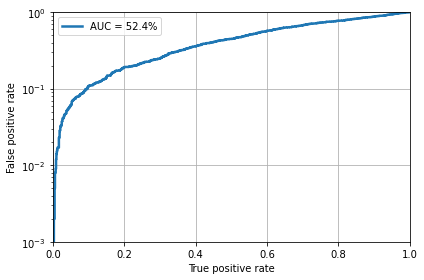

In [48]:
keras_model.load_weights('keras_model_best.h5')

# run model inference on test data set
predict_array_test = keras_model.predict(random_samples)
#print(predict_array_test)

print(label_test_numpy.shape)
print(predict_array_test.shape)

# create ROC curve
fpr, tpr, threshold = roc_curve(label_test_numpy[:,1], predict_array_test[:,1])
    
# plot ROC curve
plt.figure()
plt.plot(tpr, fpr, lw=2.5, label="AUC = {:.1f}%".format(auc(fpr,tpr)*100))
plt.xlabel(r'True positive rate')
plt.ylabel(r'False positive rate')
plt.semilogy()
plt.ylim(0.001,1)
plt.xlim(0,1)
plt.grid(True)
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('ROC.png')
plt.savefig('ROC.pdf')




In [17]:
print(label_array_test)
print(predict_array_test)
import torch
torch.argmax(torch.tensor(predict_array_test),dim=-1).sum()

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]
[[0.7944878  0.2055122 ]
 [0.94044    0.05956003]
 [0.83398634 0.16601367]
 ...
 [0.98520213 0.01479792]
 [0.7114608  0.28853917]
 [0.98474574 0.01525426]]


tensor(3330)

In [16]:
torch.tensor(label_array_test).shape

torch.Size([187723, 2])